In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, PowerTransformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
enc = LabelEncoder()
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, roc_curve, roc_auc_score, f1_score
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR, SVC


import warnings 
warnings.filterwarnings('ignore')

In [42]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import xgboost
import eli5
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
import joblib
import re

In [3]:
df = pd.read_csv('spam.csv')

In [4]:
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


# Data Preprocessing

In [5]:
df = df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'], axis=1) # deleting this columns since those are blank

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [7]:
df.isnull().sum() # Checking Null values in the data

v1    0
v2    0
dtype: int64

In [8]:
df['v1'].value_counts()

ham     4825
spam     747
Name: v1, dtype: int64

##### Data is not balanced hence we will be focusing more on precision score than test accuracy

In [9]:
df['v1'] = enc.fit_transform(df['v1']) #Enconding label to 0 and 1 where 0 refers to Ham and 1 refers to Spam

In [10]:
df

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [11]:
df.duplicated().sum() # Checking duplicate values in the data

403

In [12]:
df = df.drop_duplicates(keep='first') # Deleting duplicate values from the data

In [13]:
df.duplicated().sum()

0

# EDA

In [14]:
df['V2_Char_length'] = df['v2'].apply(len) # creating column to check the length of characters 

In [15]:
df['V2_words_length'] = df['v2'].apply(lambda x:len(nltk.word_tokenize(x))) # creating column to check the length of words 

In [16]:
df['V2_sentences_length'] = df['v2'].apply(lambda x:len(nltk.sent_tokenize(x))) # creating column to check the length of sentences

In [17]:
df.describe()

,v1,V2_Char_length,V2_words_length,V2_sentences_length
count,5169.000000,5169.000000,5169.000000,5169.000000
mean,0.126330,78.977945,18.455407,1.961308
std,0.332253,58.236293,13.322448,1.432583
min,0.000000,2.000000,1.000000,1.000000
25%,0.000000,36.000000,9.000000,1.000000
50%,0.000000,60.000000,15.000000,1.000000
75%,0.000000,117.000000,26.000000,2.000000
max,1.000000,910.000000,220.000000,38.000000


By looking at max value of V2_Char_length, V2_words_length and V2_sentences_length we can conclude that there are big mails and messages present in the data

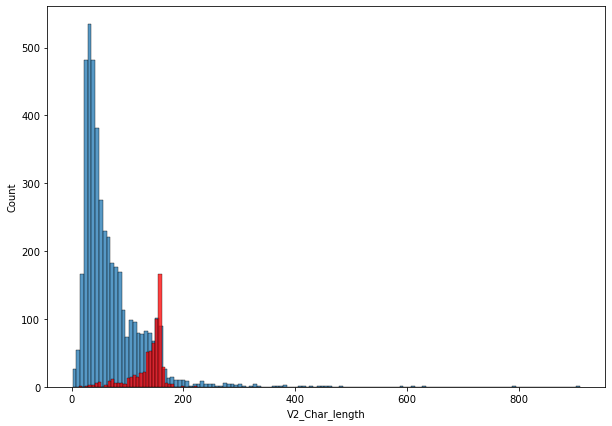

In [18]:
plt.figure(figsize=(10,7))
sns.histplot(df[df['v1'] == 0]['V2_Char_length'])
sns.histplot(df[df['v1'] == 1]['V2_Char_length'],color='red')
plt.show()

Observation - 

- Spam mails and messages contain more number of characters that ham mails and messages

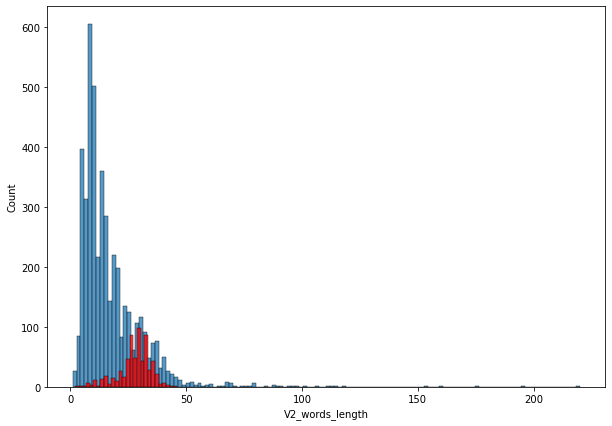

In [19]:
plt.figure(figsize=(10,7))
sns.histplot(df[df['v1'] == 0]['V2_words_length'])
sns.histplot(df[df['v1'] == 1]['V2_words_length'],color='red')
plt.show()

Observation -

- Spam mails and messages contain more number of words that ham mails and messages

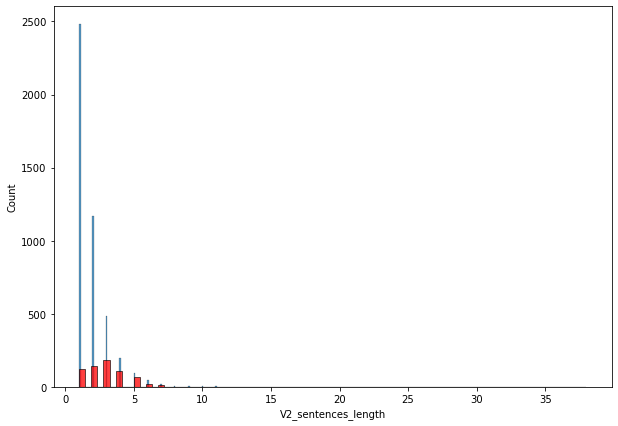

In [20]:
plt.figure(figsize=(10,7))
sns.histplot(df[df['v1'] == 0]['V2_sentences_length'])
sns.histplot(df[df['v1'] == 1]['V2_sentences_length'],color='red')
plt.show()

Observation -

- Spam mails and messages contain more number of sentences that ham mails and messages

# Data Processing

In [24]:
def text_transform(text): # defining fuction to clean the data
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    y= []
    for i in text:
        if i.isalnum():
            y.append(i)
    text = y[:]
    y.clear()
    
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
            
    text = y[:]
    y.clear()
    
    for i in text:
        y.append(PorterStemmer().stem(i))
    
    return " ".join(y)

In [25]:
df

,v1,v2,V2_Char_length,V2_words_length,V2_sentences_length
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1
...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161,35,4
5568,0,Will Ì_ b going to esplanade fr home?,37,9,1
5569,0,"Pity, * was in mood for that. So...any other s...",57,15,2
5570,0,The guy did some bitching but I acted like i'd...,125,27,1


In [26]:
df['transform_text'] = df['v2'].apply(text_transform) # Applying text_transform define function to data and creating new column for transformed data

In [27]:
df

,v1,v2,V2_Char_length,V2_words_length,V2_sentences_length,transform_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though
...,...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161,35,4,2nd time tri 2 contact u pound prize 2 claim e...
5568,0,Will Ì_ b going to esplanade fr home?,37,9,1,b go esplanad fr home
5569,0,"Pity, * was in mood for that. So...any other s...",57,15,2,piti mood suggest
5570,0,The guy did some bitching but I acted like i'd...,125,27,1,guy bitch act like interest buy someth els nex...


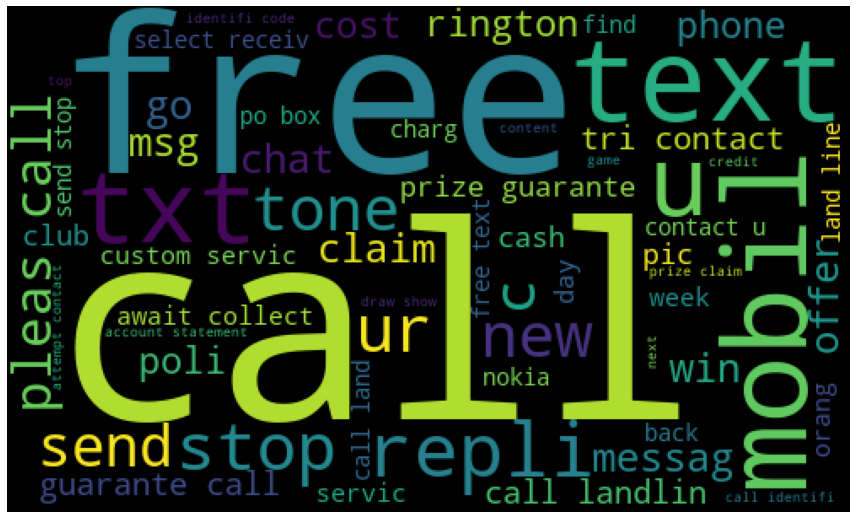

In [30]:
x1 = df['transform_text'][df['v1']==1]
x2 = WordCloud(width=500, height=300, max_words=60).generate(''.join(x1))
plt.figure(figsize=(12,10))
plt.imshow(x2)
plt.axis('off')
plt.tight_layout()
plt.show()

Observations - 

- Free, Call, Please, Text, txt are some words which are occuring for most number of time

In [87]:
cv = CountVectorizer()

X = cv.fit_transform(df['transform_text']).toarray() # converting data into vectors by using CountVectorizer and setting it for train data

In [88]:
Y = df['v1'].values # Assigning test data to variable Y

In [89]:
def print_score(clf, x_train,x_test,y_train,y_test, train=True):  # Defining fuction for model building
    if train:
        y_pred = clf.predict(x_train)
        
        print('\n===============Train Result===============')
        print(f'Accuracy Score: {accuracy_score(y_train, y_pred)*100:.2f}%')
        
        
    elif train==False:
        pred = clf.predict(x_test)
        
        print('\n===============Test Result===============')
        print(f'Accuracy Score: {accuracy_score(y_test, pred)*100:.2f}%')
        
        print('\n \n Test Classification Report \n', classification_report(y_test, pred, digits=2))
        print('\n=========================================')
        
        con_mat = confusion_matrix(y_test, pred)
        print('\nconfusion Matrix- \n', con_mat)
        print('\n=========================================')

In [90]:
gnb = GaussianNB() 
mnb = MultinomialNB() 
bnb = BernoulliNB()

## GaussianNB

In [91]:
maxAccu =0  # Checking the highest test accuracy with range of random_state from 1-100
maxRS= 0

for i in range(1,100):
    x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.25,random_state = i)
    gnb = GaussianNB()
    gnb.fit(x_train,y_train)
    y_pred=gnb.predict(x_test)
    acc=accuracy_score(y_test, y_pred)
    print('accuracy', acc,'Random_state',i)
    
    if acc>maxAccu:
        maxAccu=acc
        maxRS=i
        print('max_accuracy', maxAccu,'max_Random_state',i)

accuracy 0.8669760247486465 Random_state 1
max_accuracy 0.8669760247486465 max_Random_state 1
accuracy 0.8723897911832946 Random_state 2
max_accuracy 0.8723897911832946 max_Random_state 2
accuracy 0.8692962103634957 Random_state 3
accuracy 0.8631090487238979 Random_state 4
accuracy 0.868522815158546 Random_state 5
accuracy 0.8723897911832946 Random_state 6
accuracy 0.8747099767981439 Random_state 7
max_accuracy 0.8747099767981439 max_Random_state 7
accuracy 0.8646558391337974 Random_state 8
accuracy 0.8576952822892498 Random_state 9
accuracy 0.8623356535189481 Random_state 10
accuracy 0.8793503480278422 Random_state 11
max_accuracy 0.8793503480278422 max_Random_state 11
accuracy 0.8708430007733952 Random_state 12
accuracy 0.8747099767981439 Random_state 13
accuracy 0.8731631863882444 Random_state 14
accuracy 0.8808971384377416 Random_state 15
max_accuracy 0.8808971384377416 max_Random_state 15
accuracy 0.8584686774941995 Random_state 16
accuracy 0.8747099767981439 Random_state 17
accur

In [92]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.25,random_state = 29)

In [93]:
gnb = GaussianNB() 
gnb.fit(x_train,y_train)

print_score(gnb,x_train,x_test,y_train,y_test, train=True)
print_score(gnb,x_train,x_test,y_train,y_test, train=False)


===============Train Result===============
Accuracy Score: 92.70%

===============Test Result===============
Accuracy Score: 88.63%

 
 Test Classification Report 
               precision    recall  f1-score   support

           0       0.98      0.89      0.93      1134
           1       0.52      0.89      0.66       159

    accuracy                           0.89      1293
   macro avg       0.75      0.89      0.80      1293
weighted avg       0.93      0.89      0.90      1293



confusion Matrix- 
 [[1004  130]
 [  17  142]]



## MultinomialNB

In [94]:
maxAccu =0 # Checking the highest test accuracy with range of random_state from 1-100
maxRS= 0

for i in range(1,100):
    x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.25,random_state = i)
    mnb = MultinomialNB()
    mnb.fit(x_train,y_train)
    y_pred=mnb.predict(x_test)
    acc=accuracy_score(y_test, y_pred)
    print('accuracy', acc,'Random_state',i)
    
    if acc>maxAccu:
        maxAccu=acc
        maxRS=i
        print('max_accuracy', maxAccu,'max_Random_state',i)

accuracy 0.97138437741686 Random_state 1
max_accuracy 0.97138437741686 max_Random_state 1
accuracy 0.9659706109822119 Random_state 2
accuracy 0.97138437741686 Random_state 3
accuracy 0.9760247486465584 Random_state 4
max_accuracy 0.9760247486465584 max_Random_state 4
accuracy 0.962877030162413 Random_state 5
accuracy 0.9752513534416086 Random_state 6
accuracy 0.974477958236659 Random_state 7
accuracy 0.9644238205723125 Random_state 8
accuracy 0.9667440061871616 Random_state 9
accuracy 0.9721577726218097 Random_state 10
accuracy 0.9698375870069605 Random_state 11
accuracy 0.9737045630317092 Random_state 12
accuracy 0.9752513534416086 Random_state 13
accuracy 0.9760247486465584 Random_state 14
accuracy 0.9752513534416086 Random_state 15
accuracy 0.9667440061871616 Random_state 16
accuracy 0.9737045630317092 Random_state 17
accuracy 0.9729311678267595 Random_state 18
accuracy 0.974477958236659 Random_state 19
accuracy 0.9783449342614076 Random_state 20
max_accuracy 0.9783449342614076 max_

In [95]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.25,random_state = 36)

In [96]:
mnb = MultinomialNB() 
mnb.fit(x_train,y_train)

print_score(mnb,x_train,x_test,y_train,y_test, train=True)
print_score(mnb,x_train,x_test,y_train,y_test, train=False)


===============Train Result===============
Accuracy Score: 99.05%

===============Test Result===============
Accuracy Score: 98.14%

 
 Test Classification Report 
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      1133
           1       0.90      0.96      0.93       160

    accuracy                           0.98      1293
   macro avg       0.94      0.97      0.96      1293
weighted avg       0.98      0.98      0.98      1293



confusion Matrix- 
 [[1115   18]
 [   6  154]]



## BernoulliNB

In [97]:
maxAccu =0 
maxRS= 0

for i in range(1,100):
    x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.25,random_state = i)
    bnb = BernoulliNB()
    bnb.fit(x_train,y_train)
    y_pred=bnb.predict(x_test)
    acc=accuracy_score(y_test, y_pred)
    print('accuracy', acc,'Random_state',i)
    
    if acc>maxAccu:
        maxAccu=acc
        maxRS=i
        print('max_accuracy', maxAccu,'max_Random_state',i)

accuracy 0.9582366589327146 Random_state 1
max_accuracy 0.9582366589327146 max_Random_state 1
accuracy 0.9698375870069605 Random_state 2
max_accuracy 0.9698375870069605 max_Random_state 2
accuracy 0.9659706109822119 Random_state 3
accuracy 0.97138437741686 Random_state 4
max_accuracy 0.97138437741686 max_Random_state 4
accuracy 0.9636504253673627 Random_state 5
accuracy 0.9721577726218097 Random_state 6
max_accuracy 0.9721577726218097 max_Random_state 6
accuracy 0.9682907965970611 Random_state 7
accuracy 0.9621036349574633 Random_state 8
accuracy 0.9644238205723125 Random_state 9
accuracy 0.962877030162413 Random_state 10
accuracy 0.9667440061871616 Random_state 11
accuracy 0.9690641918020109 Random_state 12
accuracy 0.9667440061871616 Random_state 13
accuracy 0.97138437741686 Random_state 14
accuracy 0.9667440061871616 Random_state 15
accuracy 0.9621036349574633 Random_state 16
accuracy 0.97138437741686 Random_state 17
accuracy 0.9690641918020109 Random_state 18
accuracy 0.96829079659

In [98]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.25,random_state = 47)

In [99]:
bnb = BernoulliNB()
bnb.fit(x_train,y_train)

print_score(bnb,x_train,x_test,y_train,y_test, train=True)
print_score(bnb,x_train,x_test,y_train,y_test, train=False)


===============Train Result===============
Accuracy Score: 97.55%

===============Test Result===============
Accuracy Score: 98.07%

 
 Test Classification Report 
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      1152
           1       0.95      0.87      0.91       141

    accuracy                           0.98      1293
   macro avg       0.97      0.93      0.95      1293
weighted avg       0.98      0.98      0.98      1293



confusion Matrix- 
 [[1146    6]
 [  19  122]]



## LogisticRegression

In [100]:
maxAccu =0 
maxRS= 0

for i in range(1,100):
    x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.25,random_state = i)
    log = LogisticRegression()
    log.fit(x_train,y_train)
    y_pred=log.predict(x_test)
    acc=accuracy_score(y_test, y_pred)
    print('accuracy', acc,'Random_state',i)
    
    if acc>maxAccu:
        maxAccu=acc
        maxRS=i
        print('max_accuracy', maxAccu,'max_Random_state',i)

accuracy 0.9706109822119103 Random_state 1
max_accuracy 0.9706109822119103 max_Random_state 1
accuracy 0.9783449342614076 Random_state 2
max_accuracy 0.9783449342614076 max_Random_state 2
accuracy 0.9706109822119103 Random_state 3
accuracy 0.9814385150812065 Random_state 4
max_accuracy 0.9814385150812065 max_Random_state 4
accuracy 0.974477958236659 Random_state 5
accuracy 0.9767981438515081 Random_state 6
accuracy 0.97138437741686 Random_state 7
accuracy 0.9737045630317092 Random_state 8
accuracy 0.9667440061871616 Random_state 9
accuracy 0.9775715390564579 Random_state 10
accuracy 0.9721577726218097 Random_state 11
accuracy 0.9791183294663574 Random_state 12
accuracy 0.9752513534416086 Random_state 13
accuracy 0.982985305491106 Random_state 14
max_accuracy 0.982985305491106 max_Random_state 14
accuracy 0.9706109822119103 Random_state 15
accuracy 0.97138437741686 Random_state 16
accuracy 0.979891724671307 Random_state 17
accuracy 0.9752513534416086 Random_state 18
accuracy 0.976024748

In [101]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.25,random_state = 47)

In [102]:
log = LogisticRegression()
log.fit(x_train,y_train)

print_score(log,x_train,x_test,y_train,y_test, train=True)
print_score(log,x_train,x_test,y_train,y_test, train=False)


===============Train Result===============
Accuracy Score: 99.43%

===============Test Result===============
Accuracy Score: 98.69%

 
 Test Classification Report 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1152
           1       0.98      0.90      0.94       141

    accuracy                           0.99      1293
   macro avg       0.98      0.95      0.96      1293
weighted avg       0.99      0.99      0.99      1293



confusion Matrix- 
 [[1149    3]
 [  14  127]]



## KNeighborsClassifier

In [103]:
maxAccu =0 
maxRS= 0

for i in range(1,100):
    x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.25,random_state = i)
    knn = KNeighborsClassifier()
    knn.fit(x_train,y_train)
    y_pred=knn.predict(x_test)
    acc=accuracy_score(y_test, y_pred)
    print('accuracy', acc,'Random_state',i)
    
    if acc>maxAccu:
        maxAccu=acc
        maxRS=i
        print('max_accuracy', maxAccu,'max_Random_state',i)

accuracy 0.9017788089713844 Random_state 1
max_accuracy 0.9017788089713844 max_Random_state 1
accuracy 0.9110595514307811 Random_state 2
max_accuracy 0.9110595514307811 max_Random_state 2
accuracy 0.9017788089713844 Random_state 3
accuracy 0.917246713070379 Random_state 4
max_accuracy 0.917246713070379 max_Random_state 4
accuracy 0.9064191802010828 Random_state 5
accuracy 0.917246713070379 Random_state 6
accuracy 0.9040989945862336 Random_state 7
accuracy 0.9102861562258314 Random_state 8
accuracy 0.9025522041763341 Random_state 9
accuracy 0.9071925754060325 Random_state 10
accuracy 0.9095127610208816 Random_state 11
accuracy 0.9079659706109822 Random_state 12
accuracy 0.9110595514307811 Random_state 13
accuracy 0.9187935034802784 Random_state 14
max_accuracy 0.9187935034802784 max_Random_state 14
accuracy 0.9048723897911833 Random_state 15
accuracy 0.8955916473317865 Random_state 16
accuracy 0.9203402938901779 Random_state 17
max_accuracy 0.9203402938901779 max_Random_state 17
accurac

In [104]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.25,random_state = 47)

In [105]:
knn = KNeighborsClassifier()
knn.fit(x_train,y_train)

print_score(knn,x_train,x_test,y_train,y_test, train=True)
print_score(knn,x_train,x_test,y_train,y_test, train=False)


===============Train Result===============
Accuracy Score: 92.03%

===============Test Result===============
Accuracy Score: 92.50%

 
 Test Classification Report 
               precision    recall  f1-score   support

           0       0.92      1.00      0.96      1152
           1       1.00      0.31      0.48       141

    accuracy                           0.92      1293
   macro avg       0.96      0.66      0.72      1293
weighted avg       0.93      0.92      0.91      1293



confusion Matrix- 
 [[1152    0]
 [  97   44]]



## GradientBoostingClassifier

In [106]:
gbdt = GradientBoostingClassifier()
gbdt.fit(x_train,y_train)

print_score(gbdt,x_train,x_test,y_train,y_test, train=True)
print_score(gbdt,x_train,x_test,y_train,y_test, train=False)


===============Train Result===============
Accuracy Score: 97.57%

===============Test Result===============
Accuracy Score: 96.44%

 
 Test Classification Report 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1152
           1       0.92      0.74      0.82       141

    accuracy                           0.96      1293
   macro avg       0.94      0.86      0.90      1293
weighted avg       0.96      0.96      0.96      1293



confusion Matrix- 
 [[1143    9]
 [  37  104]]



## SupportVectorClassifier

In [107]:
svc = SVC()
svc.fit(x_train,y_train)

print_score(svc,x_train,x_test,y_train,y_test, train=True)
print_score(svc,x_train,x_test,y_train,y_test, train=False)


===============Train Result===============
Accuracy Score: 99.46%

===============Test Result===============
Accuracy Score: 97.68%

 
 Test Classification Report 
               precision    recall  f1-score   support

           0       0.97      1.00      0.99      1152
           1       1.00      0.79      0.88       141

    accuracy                           0.98      1293
   macro avg       0.99      0.89      0.93      1293
weighted avg       0.98      0.98      0.98      1293



confusion Matrix- 
 [[1152    0]
 [  30  111]]



## DecisionTreeClassifier

In [108]:
dtc = DecisionTreeClassifier()
dtc.fit(x_train,y_train)

print_score(dtc,x_train,x_test,y_train,y_test, train=True)
print_score(dtc,x_train,x_test,y_train,y_test, train=False)


===============Train Result===============
Accuracy Score: 100.00%

===============Test Result===============
Accuracy Score: 96.21%

 
 Test Classification Report 
               precision    recall  f1-score   support

           0       0.97      0.98      0.98      1152
           1       0.86      0.78      0.82       141

    accuracy                           0.96      1293
   macro avg       0.92      0.88      0.90      1293
weighted avg       0.96      0.96      0.96      1293



confusion Matrix- 
 [[1134   18]
 [  31  110]]



## RandomForestClassifier

In [109]:
rfc = RandomForestClassifier()
rfc.fit(x_train,y_train)

print_score(rfc,x_train,x_test,y_train,y_test, train=True)
print_score(rfc,x_train,x_test,y_train,y_test, train=False)


===============Train Result===============
Accuracy Score: 100.00%

===============Test Result===============
Accuracy Score: 97.68%

 
 Test Classification Report 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1152
           1       0.98      0.80      0.88       141

    accuracy                           0.98      1293
   macro avg       0.98      0.90      0.93      1293
weighted avg       0.98      0.98      0.98      1293



confusion Matrix- 
 [[1150    2]
 [  28  113]]



## Conclusion

In [110]:
scores = pd.DataFrame({
    'Model_Name':['RandomForestClassifier', 'DecisionTreeClassifier', 'SupportVectorClassifier', 'GradientBoostingClassifier', 'KNeighborsClassifier', 'LogisticRegression', 'BernoulliNB', 'MultinomialNB', 'GaussianNB'],
    'Accuracy':[97.68, 96.21, 97.68, 96.44, 92.50, 98.69, 98.07, 98.14, 88.63],
    'Precision_Score':[0.98, 0.86, 1.00, 0.92, 1.00, 0.98, 0.95, 0.90, 0.52],
    'Confusion_Matrix_FP':[2, 18, 0, 9, 0, 3, 6, 18, 130]
})

In [116]:
scores.sort_values(by=['Precision_Score'], ascendibng=False)

,Model_Name,Accuracy,Precision_Score,Confusion_Matrix_FP
2,SupportVectorClassifier,97.68,1.00,0
4,KNeighborsClassifier,92.50,1.00,0
0,RandomForestClassifier,97.68,0.98,2
5,LogisticRegression,98.69,0.98,3
6,BernoulliNB,98.07,0.95,6
3,GradientBoostingClassifier,96.44,0.92,9
7,MultinomialNB,98.14,0.90,18
1,DecisionTreeClassifier,96.21,0.86,18
8,GaussianNB,88.63,0.52,130


##### 1. Since the label is imbalanced we have to focus on precision score.
##### 2. SupportVectorClassifier has the highest precision score with high Accuracy hence selecting SupportVectorClassifier for further Hyper Parameter Tuning.

# Hyper Parameter Tuning

In [117]:
grid_param = {                                      # creating grid for hyper parameters
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'C': range(1,20),
    'decision_function_shape': ['ovo', 'ovr']
}

In [118]:
grid_search = GridSearchCV(estimator=svc,          # assigning SVC model to search grid CV
                          param_grid=grid_param,
                          cv=3,
                          n_jobs =-1)

In [119]:
grid_search.fit(x_train,y_train)  # searching best parameters

GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': range(1, 20),
                         'decision_function_shape': ['ovo', 'ovr'],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'sigmoid']})

In [120]:
best_parameters = grid_search.best_params_
print(best_parameters)

{'C': 1, 'decision_function_shape': 'ovo', 'gamma': 'scale', 'kernel': 'linear'}


In [127]:
svc = SVC(C= 1, decision_function_shape= 'ovo', gamma= 'scale', kernel= 'rbf')  # applying best parameters 
svc.fit(x_train,y_train)

print_score(svc,x_train,x_test,y_train,y_test, train=True)
print_score(svc,x_train,x_test,y_train,y_test, train=False)


===============Train Result===============
Accuracy Score: 99.46%

===============Test Result===============
Accuracy Score: 97.68%

 
 Test Classification Report 
               precision    recall  f1-score   support

           0       0.97      1.00      0.99      1152
           1       1.00      0.79      0.88       141

    accuracy                           0.98      1293
   macro avg       0.99      0.89      0.93      1293
weighted avg       0.98      0.98      0.98      1293



confusion Matrix- 
 [[1152    0]
 [  30  111]]



# ROC AUC Curve

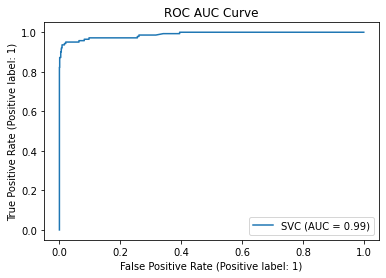

In [122]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(svc,x_test,y_test)
plt.title("ROC AUC Curve")
plt.show()

AUC Score is 99% which is pretty good 

# Saving Model

In [128]:
file = 'Email_Spam_Classifier.pickle'
pickle.dump(svc, open(file, 'wb'))